In [1]:
import sys
sys.executable

'/Users/faisal./jupyter_env/bin/python'

In [2]:
# core imports and config
import os, json, random, math, shutil
from collections import defaultdict, Counter
from pathlib import Path
from io import BytesIO
from PIL import Image
import requests
from tqdm import tqdm

# ---------- USER CONFIG ----------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# where COCO annotation files from the zip are located
CAPTIONS_FILE = "captions_val2017.json"
INSTANCES_FILE = "instances_val2017.json"
# optional local image dir if you downloaded val2017.zip
LOCAL_VAL_DIR = None   # or None to always download per-url

# output folders
OUT_ROOT = "testBed"
NEG_DIR = os.path.join(OUT_ROOT, "negation_1250")
NUM_DIR = os.path.join(OUT_ROOT, "numeracy_1250")
os.makedirs(NEG_DIR, exist_ok=True)
os.makedirs(NUM_DIR, exist_ok=True)

# Keywords: diverse mix of animals, people, furniture, vehicles, small objects
KEYWORDS = [
    "dog", "cat", "person", "car", "bicycle",
    "chair", "cup", "bottle", "book", "backpack",
    "laptop", "umbrella"
]

# Tiers thresholds: area ratio thresholds and allowed other categories
TIERS = {
    "easy": {"min_area_ratio": 0.30, "max_other_cats": 0},
    "medium": {"min_area_ratio": 0.10, "max_other_cats": 1},
    "hard": {"min_area_ratio": 0.01, "max_other_cats": 5}
}

# Dataset size targets
# NEG_TARGET = 200 defined later dw
NUM_TARGET = 1250
NEG_TARGET = 1250

# Numeracy desired per-count distribution (1..5 where 5 means 5+)
NUM_DESIRED = {1: 30, 2: 40, 3: 30, 4: 20, 5: 30}  # will be scaled to NUM_TARGET
# Allow synthetic crops to reach targets if needed
ALLOW_CROPPING = True
# Maximum relaxation steps (each halves min_area_ratio)
MAX_RELAX = 2
# ---------------------------------


In [5]:
import json
import os
#### CODE FOR EXCLUDING THE TRAIN SET IMAGES
def load_test_excludes(test_meta_path):
    """
    Returns two sets: exclude_ids (integers) and exclude_filenames (strings).
    Works for metadata formats that use either 'image_id' (int) or 'file_name' (str).
    """
    exclude_ids = set()
    exclude_filenames = set()
    if not os.path.exists(test_meta_path):
        print("Warning: test_meta_path not found:", test_meta_path)
        return exclude_ids, exclude_filenames

    with open(test_meta_path, "r") as f:
        test_meta = json.load(f)

    for e in test_meta:
        if isinstance(e, dict):
            if "image_id" in e and e["image_id"] is not None:
                try:
                    exclude_ids.add(int(e["image_id"]))
                except Exception:
                    exclude_filenames.add(str(e["image_id"]))
            if "file_name" in e and e["file_name"]:
                exclude_filenames.add(os.path.basename(e["file_name"]))
            # support alternate keys
            if "image" in e:  # e.g., spatial_mcq uses "image": "images/xxx.png"
                exclude_filenames.add(os.path.basename(e["image"]))
            if "base_image" in e:
                exclude_filenames.add(os.path.basename(e["base_image"]))
            if "swap_image" in e:
                exclude_filenames.add(os.path.basename(e["swap_image"]))
    return exclude_ids, exclude_filenames

# Example:
test_meta_path = "coco_datasets/negation_200/negation_metadata.json"   # change path to your test metadata
exclude_ids, exclude_filenames = load_test_excludes(test_meta_path)
print("Exclude IDs:", len(exclude_ids), "Exclude filenames:", len(exclude_filenames))


Exclude IDs: 200 Exclude filenames: 200


In [3]:
from pycocotools.coco import COCO

assert os.path.exists(CAPTIONS_FILE), f"captions file not found: {CAPTIONS_FILE}"
assert os.path.exists(INSTANCES_FILE), f"instances file not found: {INSTANCES_FILE}"

coco_caps = COCO(CAPTIONS_FILE)
coco_inst = COCO(INSTANCES_FILE)

# helper map: category id -> name, and name->id
catId_to_name = {c['id']: c['name'] for c in coco_inst.loadCats(coco_inst.getCatIds())}
name_to_catId = {v:k for k,v in catId_to_name.items()}
print("COCO categories loaded. Example:", list(catId_to_name.items())[:6])

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
COCO categories loaded. Example: [(1, 'person'), (2, 'bicycle'), (3, 'car'), (4, 'motorcycle'), (5, 'airplane'), (6, 'bus')]


In [4]:
def download_image_by_info(img_info, convert_rgb=True):
    """Download image via coco_url and return PIL.Image."""
    url = img_info.get("coco_url")
    if url is None:
        raise RuntimeError("no coco_url for image")
    r = requests.get(url, timeout=15)
    img = Image.open(BytesIO(r.content))
    if convert_rgb:
        img = img.convert("RGB")
    return img

def get_local_or_download(img_info):
    """Use LOCAL_VAL_DIR if available, else download via URL."""
    fname = img_info['file_name']
    if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, fname)):
        return Image.open(os.path.join(LOCAL_VAL_DIR, fname)).convert("RGB")
    else:
        return download_image_by_info(img_info)

def crop_and_resize_around_bbox(img, bbox, out_size=(512,512), pad_ratio=0.25):
    x,y,w,h = bbox
    cx = x + w/2; cy = y + h/2
    pad_w = w * pad_ratio; pad_h = h * pad_ratio
    left = max(0, int(cx - (w/2 + pad_w)))
    top  = max(0, int(cy - (h/2 + pad_h)))
    right = min(img.width, int(cx + (w/2 + pad_w)))
    bottom = min(img.height, int(cy + (h/2 + pad_h)))
    crop = img.crop((left, top, right, bottom))
    return crop.resize(out_size, Image.LANCZOS)

def save_image_to_folder(img, out_folder, out_name):
    os.makedirs(out_folder, exist_ok=True)
    out_path = os.path.join(out_folder, out_name)
    img.save(out_path)
    return out_path


def get_images_with_category(cat_name):
    """Return list of image dicts (coco image info) that contain at least one instance of cat_name."""
    if cat_name not in name_to_catId:
        print(f"[warn] category {cat_name} not in COCO categories")
        return []
    cid = name_to_catId[cat_name]
    img_ids = coco_inst.getImgIds(catIds=[cid])
    imgs = [coco_inst.loadImgs(i)[0] for i in img_ids]
    return imgs

def image_instances_info(img_id, cat_name=None):
    """Return list of annotations for this image; optionally filter by cat_name."""
    ann_ids = coco_inst.getAnnIds(imgIds=[img_id])
    anns = coco_inst.loadAnns(ann_ids)
    if cat_name:
        cid = name_to_catId.get(cat_name)
        if cid is None:
            return []
        anns = [a for a in anns if a['category_id'] == cid]
    return anns


In [6]:
# helper to evaluate an image candidate for tier constraints
def passes_tier(anns, img_info, tier_cfg, target_cat_id):
    # count other categories
    other_cats = {a['category_id'] for a in anns if a['category_id'] != target_cat_id}
    if len(other_cats) > tier_cfg['max_other_cats']:
        return False
    img_area = img_info['width'] * img_info['height']
    target_area = sum(a.get('area',0) for a in anns if a['category_id'] == target_cat_id)
    area_ratio = target_area / img_area if img_area>0 else 0
    return area_ratio >= tier_cfg['min_area_ratio']

def build_negation_dataset(keywords, tiers, neg_target=100, allow_cropping=True,
                           max_relax=2, exclude_ids=None, exclude_filenames=None):
    """
    Build negation dataset but avoid any images in exclude_ids or exclude_filenames.
    """
    exclude_ids = set(exclude_ids or [])
    exclude_filenames = set(os.path.basename(x) for x in (exclude_filenames or []))

    per_keyword_target = max(1, neg_target // len(keywords))  # rough allocation
    print("Per-keyword approx target:", per_keyword_target)
    metadata = []
    used_img_ids = set()

    for kw in keywords:
        print(f"\nCollecting for keyword: {kw}")
        if kw not in name_to_catId:
            print("  [skip] not a COCO category")
            continue
        cid = name_to_catId[kw]
        imgs = get_images_with_category(kw)
        random.shuffle(imgs)

        # for each tier, attempt collection with relaxation
        for tier_name, cfg in tiers.items():
            collected = 0
            relax = 0
            needed = int(round(per_keyword_target * (0.30 if tier_name=='easy' else 0.40 if tier_name=='medium' else 0.30)))
            # loop relax steps
            while collected < needed and relax <= max_relax:
                cur_cfg = dict(cfg)
                cur_cfg['min_area_ratio'] = cfg['min_area_ratio'] / (2**relax)
                cur_cfg['max_other_cats'] = cfg['max_other_cats'] + relax
                # scan images
                for img in imgs:
                    if collected >= needed:
                        break
                    # === NEW: exclude test images by id or filename ===
                    if img['id'] in exclude_ids:
                        continue
                    if os.path.basename(img.get('file_name','')) in exclude_filenames:
                        continue
                    if img['id'] in used_img_ids:
                        continue
                    # ===================================================
                    anns = image_instances_info(img['id'])  # all anns
                    if not anns:
                        continue
                    if not passes_tier(anns, img, cur_cfg, cid):
                        continue
                    # pass -> collect
                    target_anns = [a for a in anns if a['category_id']==cid]
                    img_area = img['width']*img['height']
                    total_target_area = sum(a.get('area',0) for a in target_anns)
                    area_ratio = total_target_area / img_area if img_area>0 else 0.0
                    # prepare metadata entry
                    file_name = img['file_name']
                    # === more defensive: double-check filename exclusion ===
                    if os.path.basename(file_name) in exclude_filenames:
                        continue

                    entry = {
                        "image_id": img['id'],
                        "file_name": file_name,
                        "keyword": kw,
                        "tier": tier_name,
                        "synthetic": False,
                        "num_instances": len(target_anns),
                        "total_target_area": total_target_area,
                        "img_area": img_area,
                        "area_ratio": area_ratio,
                        "other_categories_present": list({a['category_id'] for a in anns if a['category_id']!=cid}),
                        "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img['id']]))]
                    }
                    metadata.append(entry)
                    used_img_ids.add(img['id'])
                    collected += 1
                relax += 1

            # if still short and cropping allowed, create synthetic crops from images that have the object
            if allow_cropping and collected < needed:
                print(f"   need {needed-collected} synthetic crops for {kw}/{tier_name}")
                # consider remaining images (not used) that have the object
                candidate_ids = [im['id'] for im in imgs if im['id'] not in used_img_ids and im['id'] not in exclude_ids]
                for img_id in candidate_ids:
                    if collected >= needed:
                        break
                    # double-check exclude filename if possible
                    try:
                        img_info = coco_inst.loadImgs([img_id])[0]
                    except Exception:
                        continue
                    if os.path.basename(img_info.get('file_name','')) in exclude_filenames:
                        continue

                    anns = image_instances_info(img_id, kw)
                    if not anns:
                        continue
                    # pick largest bbox
                    anns = sorted(anns, key=lambda a: a.get('area',0), reverse=True)
                    bbox = anns[0]['bbox']
                    try:
                        img_pil = get_local_or_download(img_info)
                        # Before cropping ensure the *source image* isn't a test image (we already checked IDs and filenames)
                        crop = crop_and_resize_around_bbox(img_pil, bbox, out_size=(512,512), pad_ratio=0.25)
                        # save cropped image with new name
                        new_name = f"{img_id}_crop_{kw}_{tier_name}.jpg"
                        save_image_to_folder(crop, NEG_DIR, new_name)
                        # create entry and mark synthetic
                        entry = {
                            "image_id": img_id,
                            "file_name": new_name,
                            "keyword": kw,
                            "tier": tier_name,
                            "synthetic": True,
                            "num_instances": len(anns),
                            "total_target_area": anns[0].get('area',0),
                            "img_area": crop.width*crop.height,
                            "area_ratio": 1.0,
                            "other_categories_present": [],
                            "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))],
                            "creation_note": "cropped_to_make_object_dominant"
                        }
                        metadata.append(entry)
                        used_img_ids.add(img_id)  # avoid reuse
                        collected += 1
                    except Exception as e:
                        # skip if download or crop fails
                        continue

            print(f"  collected for {kw}/{tier_name}: {collected}/{needed}")

    # ... rest of your function unchanged but with the same exclusion checks where you copy/download images
    # when copying/downloading, skip entries whose file_name basename is in exclude_filenames or whose image_id in exclude_ids

    # Example when copying:
    copied = 0
    for entry in metadata:
        if entry['synthetic']:
            continue  # already saved
        if entry['image_id'] in exclude_ids:
            # defensive: remove any accidentally appended entries
            continue
        if os.path.basename(entry['file_name']) in exclude_filenames:
            continue
        src_name = entry['file_name']
        if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, src_name)):
            shutil.copy2(os.path.join(LOCAL_VAL_DIR, src_name), os.path.join(NEG_DIR, src_name))
            copied += 1
        else:
            img_info = coco_inst.loadImgs([entry['image_id']])[0]
            try:
                img = download_image_by_info(img_info)
                img.save(os.path.join(NEG_DIR, src_name))
                copied += 1
            except Exception:
                pass

    # ... finalize captions & return metadata
    for e in metadata:
        kw = e['keyword']
        e['correct_caption'] = f"There is a {kw} in the image."
        e['negated_caption'] = f"There is not a {kw} in the image."
        e['task'] = 'negation'

    print(f"\n'Present Object' dataset part built: {len(metadata)} items.")
    return metadata, used_img_ids


In [9]:
import os
import shutil
import random
import json

def build_absent_object_dataset(KEYWORDS, target_absent_count, used_img_ids):
    """
    Builds a dataset of images that *do not* contain the target keywords.
    Fills to target_absent_count.
    Relies on global vars: KEYWORDS, coco_inst, coco_caps, name_to_catId, 
                             NEG_DIR, LOCAL_VAL_DIR.
    Assumes helper 'download_image_by_info' exists.
    """
    print("\n--- Building Absent Object Dataset ---")
    metadata = []
    # Calculate target per keyword
    per_keyword_target = max(1, target_absent_count // len(KEYWORDS))
    print(f"Per-keyword approx target (absent): {per_keyword_target}")

    all_img_ids = set(coco_inst.getImgIds())
    
    for kw in KEYWORDS:
        print(f"\nCollecting 'absent' images for keyword: {kw}")
        if kw not in name_to_catId:
            print(f"  [skip] '{kw}' not a COCO category")
            continue
            
        cid = name_to_catId[kw]
        
        # 1. Get all image IDs that *contain* the keyword
        img_ids_with_kw = set(coco_inst.getImgIds(catIds=[cid]))
        
        # 2. Get candidate pool:
        #    (All IDs) - (IDs WITH keyword) - (IDs ALREADY USED)
        candidate_img_ids = (all_img_ids - img_ids_with_kw) - used_img_ids
        
        if not candidate_img_ids:
            print(f"  [skip] No unused images found that lack '{kw}'")
            continue

        candidate_img_ids = list(candidate_img_ids)
        random.shuffle(candidate_img_ids)
        
        collected = 0
        for img_id in candidate_img_ids:
            if collected >= per_keyword_target:
                break
                
            img_info = coco_inst.loadImgs([img_id])[0]
            
            # Ensure the image is not empty
            ann_ids = coco_inst.getAnnIds(imgIds=[img_id])
            if not ann_ids:
                continue
                
            # --- File Handling (Copy/Download) ---
            src_name = img_info['file_name']
            dest_path = os.path.join(NEG_DIR, src_name)
            
            if not os.path.exists(dest_path):
                if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, src_name)):
                    shutil.copy2(os.path.join(LOCAL_VAL_DIR, src_name), dest_path)
                else:
                    try:
                        img = download_image_by_info(img_info) 
                        img.save(dest_path)
                    except Exception as e:
                        print(f"  [skip] Failed to download {src_name}: {e}")
                        continue
            
            # --- Create Metadata Entry ---
            present_anns = coco_inst.loadAnns(ann_ids)
            present_cat_ids = list({a['category_id'] for a in present_anns})
            
            entry = {
                "image_id": img_info['id'],
                "file_name": img_info['file_name'],
                "keyword": kw,  # The keyword that is *absent*
                "tier": "absent",
                "synthetic": False,
                "num_instances": 0,
                "total_target_area": 0,
                "img_area": img_info['width'] * img_info['height'],
                "area_ratio": 0.0,
                "other_categories_present": present_cat_ids,
                "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))],
                "creation_note": f"image does not contain {kw}"
            }
            
            entry['correct_caption'] = f"There is not a {kw} in the image."
            entry['negated_caption'] = f"There is a {kw} in the image."
            entry['task'] = 'negation_absent' 

            metadata.append(entry)
            used_img_ids.add(img_id) 
            collected += 1
            
        print(f"  collected for {kw}/absent: {collected}/{per_keyword_target}")

    # --- NEW: Fill Shortage Logic ---
    if len(metadata) < target_absent_count:
        print(f"Filling shortage for absent objects... (Need {target_absent_count - len(metadata)} more)")
        
        # Create a pool of all images that don't have *any* of our keywords
        # This is a good "general purpose" pool of absent images
        all_keyword_cat_ids = {name_to_catId[kw] for kw in KEYWORDS if kw in name_to_catId}
        all_img_ids_with_any_keyword = set(coco_inst.getImgIds(catIds=list(all_keyword_cat_ids)))
        
        # Pool = (All IDs) - (IDs with *any* keyword) - (IDs already used)
        candidate_pool = list((all_img_ids - all_img_ids_with_any_keyword) - used_img_ids)
        random.shuffle(candidate_pool)
        
        if not candidate_pool:
            print("  [Warning] No more 'keyword-free' images left to fill shortage.")

        for img_id in candidate_pool:
            if len(metadata) >= target_absent_count:
                break # We're full!
                
            # Pick a random keyword to be "absent" for this image
            # We know none of our keywords are in it, so any is fine
            kw_use = random.choice(KEYWORDS)
            img_info = coco_inst.loadImgs([img_id])[0]
            
            # --- File Handling (Copy/Download) ---
            src_name = img_info['file_name']
            dest_path = os.path.join(NEG_DIR, src_name)
            
            if not os.path.exists(dest_path):
                if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, src_name)):
                    shutil.copy2(os.path.join(LOCAL_VAL_DIR, src_name), dest_path)
                else:
                    try:
                        img = download_image_by_info(img_info) 
                        img.save(dest_path)
                    except Exception as e:
                        print(f"  [skip] Failed to download {src_name}: {e}")
                        continue
            
            # --- Create Metadata Entry ---
            ann_ids = coco_inst.getAnnIds(imgIds=[img_id])
            present_cat_ids = []
            captions_data = []
            if ann_ids: # Image might have annotations for keywords we don't care about
                present_anns = coco_inst.loadAnns(ann_ids)
                present_cat_ids = list({a['category_id'] for a in present_anns})
                captions_data = [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))]

            entry = {
                "image_id": img_info['id'],
                "file_name": img_info['file_name'],
                "keyword": kw_use, # The randomly chosen absent keyword
                "tier": "absent_fill", # Mark as from the fill-in pool
                "synthetic": False,
                "num_instances": 0,
                "total_target_area": 0,
                "img_area": img_info['width'] * img_info['height'],
                "area_ratio": 0.0,
                "other_categories_present": present_cat_ids,
                "captions": captions_data,
                "creation_note": f"image does not contain {kw_use} (from fill pool)"
            }
            
            entry['correct_caption'] = f"There is not a {kw_use} in the image."
            entry['negated_caption'] = f"There is a {kw_use} in the image."
            entry['task'] = 'negation_absent' 

            metadata.append(entry)
            used_img_ids.add(img_id)

    # --- End of Fill Shortage Logic ---

    print(f"\n'Absent Object' dataset part built: {len(metadata)} items.")
    return metadata, used_img_ids

In [10]:
TARGET_PRESENT = 625
TARGET_ABSENT = 625

print("===== STARTING: Building PRESENT Object Dataset =====")

present_metadata, used_ids = build_negation_dataset(KEYWORDS, TIERS, neg_target=TARGET_PRESENT, allow_cropping=ALLOW_CROPPING, max_relax=MAX_RELAX, exclude_ids=exclude_ids,
                                                    exclude_filenames=exclude_filenames)
print(f"\nTotal images used so far: {len(used_ids)}")

print("\n===== STARTING: Building ABSENT Object Dataset =====")
absent_metadata, final_used_ids = build_absent_object_dataset(
    KEYWORDS, 
    target_absent_count=TARGET_ABSENT,
    used_img_ids=used_ids 
)

print(f"\nTotal images used in total: {len(final_used_ids)}")

# --- Combine and Save Final Dataset ---
full_metadata = present_metadata + absent_metadata
random.shuffle(full_metadata)

# Save to the *original* filename you wanted
final_meta_path = os.path.join(NEG_DIR, "negation_metadata.json")

with open(final_meta_path, "w") as f:
    json.dump(full_metadata, f, indent=2)

print(f"\n--- DONE ---")
print(f"Total items in final dataset: {len(full_metadata)}")
print(f"  Present objects: {len(present_metadata)}")
print(f"  Absent objects: {len(absent_metadata)}")
print(f"Final combined metadata saved to: {final_meta_path}")

===== STARTING: Building PRESENT Object Dataset =====
Per-keyword approx target: 52

  collected for dog/easy: 16/16
  collected for dog/medium: 21/21
  collected for dog/hard: 16/16

  collected for cat/easy: 16/16
  collected for cat/medium: 21/21
  collected for cat/hard: 16/16

  collected for person/easy: 16/16
  collected for person/medium: 21/21
  collected for person/hard: 16/16

  collected for car/easy: 16/16
  collected for car/medium: 21/21
  collected for car/hard: 16/16

  collected for bicycle/easy: 16/16
   need 4 synthetic crops for bicycle/medium
  collected for bicycle/medium: 21/21
  collected for bicycle/hard: 16/16

  collected for chair/easy: 16/16
  collected for chair/medium: 21/21
  collected for chair/hard: 16/16

   need 9 synthetic crops for cup/easy
  collected for cup/easy: 16/16
  collected for cup/medium: 21/21
  collected for cup/hard: 16/16

   need 8 synthetic crops for bottle/easy
  collected for bottle/easy: 16/16
  collected for bottle/medium: 21/

In [13]:
def pluralize(word, n):
    if n == 1:
        return word
    if word.endswith(('s','x','z','ch','sh')):
        return word + 'es'
    if word.endswith('y') and (len(word)>1 and word[-2] not in 'aeiou'):
        return word[:-1] + 'ies'
    return word + 's'

def make_count_caption(n, keyword):
    if n == 0:
        return f"There are no {pluralize(keyword,2)} in the image."
    if n == 1:
        return f"There is 1 {keyword} in the image."
    return f"There are {n} {pluralize(keyword,n)} in the image."

def build_numeracy_dataset_from_scratch(keywords, num_target=150, num_desired=None,
                                        allow_download=True, exclude_ids=None, exclude_filenames=None):
    """
    Build numeracy dataset reproducibly from COCO val annotations while excluding any images
    listed in exclude_ids or exclude_filenames.
    - exclude_ids: iterable of integer image IDs
    - exclude_filenames: iterable of filenames (or basenames)
    """
    exclude_ids = set(exclude_ids or [])
    exclude_filenames = set(os.path.basename(x) for x in (exclude_filenames or []))

    if num_desired is None:
        num_desired = {1:1,2:1,3:1,4:1,5:1}
    # scale distribution to num_target
    s = sum(num_desired.values())
    desired = {k: max(1, int(round(v * (num_target / s)))) for k,v in num_desired.items()}
    # adjust rounding to exactly num_target
    cur_sum = sum(desired.values())
    while cur_sum != num_target:
        if cur_sum < num_target:
            k = max(desired.keys())
            desired[k] += 1
            cur_sum += 1
        else:
            k = max(desired.keys())
            if desired[k] > 1:
                desired[k] -= 1
                cur_sum -=1
            else:
                break
    print("Desired per-count (1..5 where 5 = 5+):", desired)

    # Build candidate pool
    print("Scanning COCO for candidate images (this may take ~1-2 min)...")
    all_img_ids = set()
    for kw in keywords:
        cid = name_to_catId.get(kw)
        if cid is None:
            print(f"[warn] {kw} not found in COCO categories, skipping.")
            continue
        ids = coco_inst.getImgIds(catIds=[cid])
        all_img_ids.update(ids)
    all_img_ids = list(all_img_ids)
    random.shuffle(all_img_ids)

    candidates = []
    for img_id in all_img_ids:
        if img_id in exclude_ids:
            continue
        img_info = coco_inst.loadImgs([img_id])[0]
        fname = img_info.get('file_name') or ""
        if os.path.basename(fname) in exclude_filenames:
            continue
        anns = image_instances_info(img_id)
        # count occurrences per keyword
        counts = {}
        for a in anns:
            cat_name = catId_to_name.get(a['category_id'])
            if cat_name in keywords:
                counts[cat_name] = counts.get(cat_name, 0) + 1
        if not counts:
            continue
        dom_kw, dom_count = max(counts.items(), key=lambda kv: (kv[1], kv[0]))
        candidates.append((img_info, dom_kw, dom_count))

    print("Total candidate images containing keywords (after exclude filter):", len(candidates))

    # bucket by count (clip 5+ to 5)
    buckets = defaultdict(list)
    for img_info, kw, cnt in candidates:
        key = 5 if cnt >= 5 else cnt
        # skip if filename excluded defensively
        if os.path.basename(img_info.get('file_name','')) in exclude_filenames:
            continue
        buckets[key].append((img_info, kw, cnt))

    # sample from buckets per desired distribution
    selected = []
    for cnt_bucket, want in desired.items():
        pool = buckets.get(cnt_bucket, [])
        take = min(len(pool), want)
        if take > 0:
            selected.extend(random.sample(pool, take))

    # If shortage, try to fill from other buckets (prefer higher counts)
    if len(selected) < num_target:
        remaining = []
        for k in sorted(buckets.keys(), reverse=True):  # higher counts first
            remaining.extend([t for t in buckets[k] if t not in selected])
        needed = num_target - len(selected)
        selected.extend(remaining[:needed])

    print("Selected images (pre-download):", len(selected))

    # build metadata entries and download/copy images
    metadata = []
    for img_info, kw, cnt in selected:
        img_id = img_info['id']
        fname = img_info['file_name']
        # final defensive exclude check
        if img_id in exclude_ids or os.path.basename(fname) in exclude_filenames:
            continue

        out_path = os.path.join(NUM_DIR, fname)
        # ensure output directory exists
        os.makedirs(NUM_DIR, exist_ok=True)
        # copy from LOCAL_VAL_DIR if available
        if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, fname)):
            shutil.copy2(os.path.join(LOCAL_VAL_DIR, fname), out_path)
        else:
            if not allow_download:
                print("Skipping download (allow_download=False) for", img_id)
                continue
            try:
                img = download_image_by_info(img_info)
                img.save(out_path)
            except Exception as e:
                print("Download failed for", img_id, "skipping", e)
                continue

        # create explicit captions (use dominant kw)
        correct = make_count_caption(cnt, kw)
        foils = []
        if cnt-1 >= 0:
            foils.append(make_count_caption(max(0, cnt-1), kw))
        foils.append(make_count_caption(cnt+1, kw))

        meta = {
            "image_id": img_id,
            "file_name": fname,
            "keyword": kw,
            "num_instances": cnt,
            "count_bucket": 5 if cnt>=5 else cnt,
            "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))],
            "correct_caption": correct,
            "foils": foils,
            "task": "numeracy",
            "synthetic": False
        }
        metadata.append(meta)

    # trim to exact num_target (in case downloads omitted some)
    if len(metadata) > num_target:
        metadata = random.sample(metadata, num_target)

    # final save
    out_json = os.path.join(NUM_DIR, "numeracy_metadata_fixed.json")
    with open(out_json, "w") as f:
        json.dump(metadata, f, indent=2)
    print("Saved numeracy metadata to", out_json, "   total items:", len(metadata))
    return metadata

In [14]:
def verify_no_overlap(train_meta_path, test_meta_path):
    import json, os
    train = json.load(open(train_meta_path))
    test  = json.load(open(test_meta_path))
    train_ids = set()
    train_files = set()
    for e in train:
        if "image_id" in e:
            try: train_ids.add(int(e["image_id"]))
            except: pass
        if "file_name" in e:
            train_files.add(os.path.basename(e["file_name"]))
        if "image" in e:
            train_files.add(os.path.basename(e["image"]))
    test_ids = set()
    test_files = set()
    for e in test:
        if "image_id" in e:
            try: test_ids.add(int(e["image_id"]))
            except: pass
        if "file_name" in e:
            test_files.add(os.path.basename(e["file_name"]))
        if "image" in e:
            test_files.add(os.path.basename(e["image"]))
    id_inter = train_ids.intersection(test_ids)
    file_inter = train_files.intersection(test_files)
    print("ID overlap count:", len(id_inter))
    print("Filename overlap count:", len(file_inter))
    if id_inter:
        print("Example overlapping IDs:", list(id_inter)[:10])
    if file_inter:
        print("Example overlapping filenames:", list(file_inter)[:10])
    return id_inter, file_inter

# Example call after building train:
# train_meta_path = os.path.join(NUM_DIR, "numeracy_metadata_fixed.json")
# test_meta_path = "coco_datasets/negation_200/negation_metadata.json"  # adjust to your test
# verify_no_overlap(train_meta_path, test_meta_path)


In [17]:
# 1. load excludes from your test set(s)
test_meta_path = "coco_datasets/negation_200/negation_metadata.json"  # change to your actual test metadata path(s)
exclude_ids, exclude_filenames = load_test_excludes(test_meta_path)

# 2. build numeracy dataset while excluding test images
metadata = build_numeracy_dataset_from_scratch(KEYWORDS, NUM_TARGET,
                                               allow_download=True,
                                               exclude_ids=exclude_ids,
                                               exclude_filenames=exclude_filenames)

# 3. verify no overlap with test
train_meta_path = os.path.join(NUM_DIR, "numeracy_metadata_fixed.json")
verify_no_overlap(train_meta_path, test_meta_path)

Desired per-count (1..5 where 5 = 5+): {1: 250, 2: 250, 3: 250, 4: 250, 5: 250}
Scanning COCO for candidate images (this may take ~1-2 min)...
Total candidate images containing keywords (after exclude filter): 3430
Selected images (pre-download): 1250
Saved numeracy metadata to testBed/numeracy_1250/numeracy_metadata_fixed.json    total items: 1250
ID overlap count: 0
Filename overlap count: 0


(set(), set())

Total items: 1261
By keyword (top): [('bicycle', 106), ('person', 105), ('book', 105), ('cup', 105), ('bottle', 105), ('dog', 105), ('umbrella', 105), ('chair', 105), ('backpack', 105), ('laptop', 105)]
By tier: {'absent': 624, 'easy': 192, 'medium': 252, 'hard': 192, 'absent_fill': 1}
Synthetic crops: 53
Total items: 1250
By keyword (top): [('person', 798), ('car', 119), ('chair', 80), ('cup', 71), ('bottle', 56), ('book', 46), ('cat', 23), ('dog', 20), ('umbrella', 14), ('laptop', 13)]
By tier: {}
Synthetic crops: 0

Negation samples:


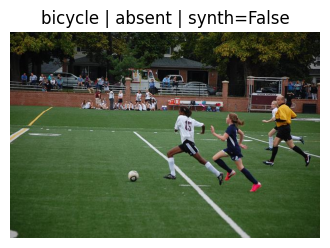

Correct: There is not a bicycle in the image.
----------------------------------------


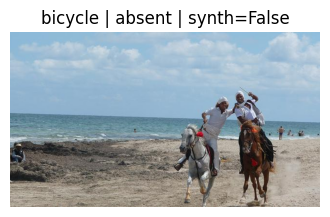

Correct: There is not a bicycle in the image.
----------------------------------------


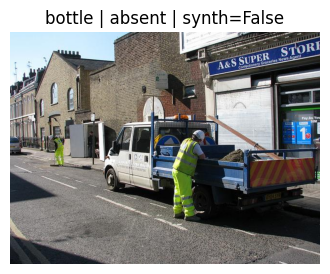

Correct: There is not a bottle in the image.
----------------------------------------


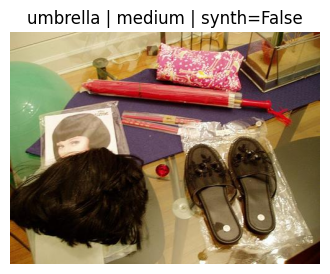

Correct: There is a umbrella in the image.
Negated: There is not a umbrella in the image.
----------------------------------------

Numeracy samples:


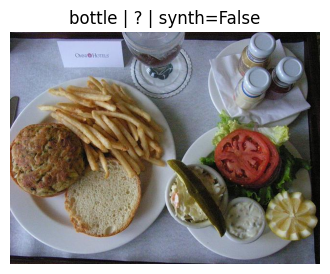

Correct: There are 3 bottles in the image.
Foils: There are 2 bottles in the image.
There are 4 bottles in the image.
----------------------------------------


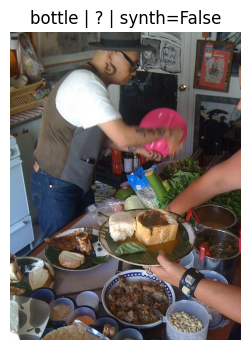

Correct: There are 4 bottles in the image.
Foils: There are 3 bottles in the image.
There are 5 bottles in the image.
----------------------------------------


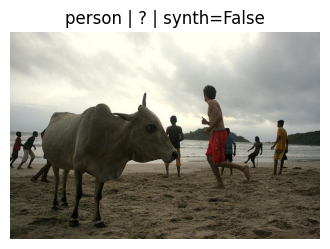

Correct: There are 8 persons in the image.
Foils: There are 7 persons in the image.
There are 9 persons in the image.
----------------------------------------


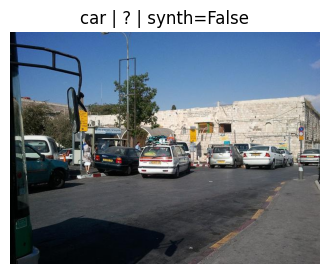

Correct: There are 11 cars in the image.
Foils: There are 10 cars in the image.
There are 12 cars in the image.
----------------------------------------


In [19]:
# Summaries for negation and numeracy sets
def summary_from_meta(meta_path, folder):
    with open(meta_path) as f:
        data = json.load(f)
    print("Total items:", len(data))
    cnt_kw = Counter([d.get('keyword','mixed') for d in data if 'keyword' in d])
    cnt_tier = Counter([d.get('tier','unknown') for d in data if 'tier' in d])
    cnt_synth = sum(1 for d in data if d.get('synthetic', False))
    print("By keyword (top):", cnt_kw.most_common(10))
    print("By tier:", dict(cnt_tier))
    print("Synthetic crops:", cnt_synth)
    return data

neg_meta_path = os.path.join(NEG_DIR, "negation_metadata.json")
num_meta_path = os.path.join(NUM_DIR, "numeracy_metadata_fixed.json")

neg_data = summary_from_meta(neg_meta_path, NEG_DIR)
num_data = summary_from_meta(num_meta_path, NUM_DIR)

# show sample images from each set
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_samples(data, folder, n=4):
    sample = random.sample(data, min(len(data), n))
    for s in sample:
        img_path = os.path.join(folder, s['file_name'])
        try:
            img = Image.open(img_path)
            plt.figure(figsize=(4,4))
            plt.imshow(img); plt.axis('off')
            title = f"{s.get('keyword','?')} | {s.get('tier','?')} | synth={s.get('synthetic', False)}"
            plt.title(title)
            plt.show()
            print("Correct:", s.get('correct_caption'))
            if s.get('task')=='numeracy':
                # print("Foils:", s.get('foils'))
                print("Foils:",end=" ")
                for foil in s.get('foils'):
                  print(foil)
            if s.get('task')=='negation':
                print("Negated:", s.get('negated_caption'))
            print("-"*40)
        except Exception as e:
            print("Error showing", s['file_name'], e)

print("\nNegation samples:")
show_samples(neg_data, NEG_DIR, n=4)
print("\nNumeracy samples:")
show_samples(num_data, NUM_DIR, n=4)


In [33]:
# spatial MCQ generator with occlusion nudge (drop-in)
import os, random, json, math
from collections import Counter
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import shutil
import glob

# ---------------- GLOBAL CONFIG (KEEP) ----------------
# Domain choices and constants used inside the function
IMG_SIZE = (512, 512)
MARGIN = 40
SHAPES = ["cube", "sphere", "cylinder", "triangle", "star", "hexagon"]
COLORS = ["red","blue","green","yellow","purple","orange","brown","gray"]
COLOR_MAP = {
    "red":(220,50,50), "blue":(50,100,220), "green":(60,160,80), "yellow":(235,210,60),
    "purple":(150,80,200), "orange":(230,120,40), "brown":(160,100,60), "gray":(140,140,140)
}
SIZES = {"small": 56, "medium": 96, "large": 140}
SIZE_BUCKETS = list(SIZES.keys())
BG_STYLES = ["plain", "noise", "gradient"]
ROTATION_RANGE = (-15, 15)
OVERLAP_PROB = 0.25
SHADOW = True
ANTIALIAS = True
# ----------------------------------------------------


# --- ALL YOUR HELPER FUNCTIONS GO HERE ---
# (make_background, draw_shape_on_layer, add_shadow, make_background (2nd time), 
# intersection_area, clamp_bbox_to_image, ensure_min_visibility, etc.
# -- OMITTED FOR BREVITY, BUT ASSUME THEY ARE HERE --

def draw_shape_on_layer(shape, bbox, color, rotation=0):
    # [ ... your draw_shape_on_layer code ... ]
    # NOTE: Assuming this is the correct implementation of your helpers.
    x0,y0,x1,y1 = bbox
    w = x1 - x0
    h = y1 - y0
    layer = Image.new("RGBA", (w, h), (0,0,0,0))
    draw = ImageDraw.Draw(layer)
    outline = (30,30,30,255)
    stroke = max(2, int(min(w,h)/25))
    if shape == "sphere":
        draw.ellipse([0,0,w,h], fill=color+(255,), outline=outline, width=stroke)
    elif shape == "cube":
        draw.rectangle([0,0,w,h], fill=color+(255,), outline=outline, width=stroke)
        strip_h = max(4, int(h*0.06))
        draw.rectangle([int(w*0.06), int(h*0.06), int(w*0.94), int(h*0.06)+strip_h], fill=(255,255,255,60))
    elif shape == "cylinder":
        draw.rectangle([0,int(h*0.12),w,int(h*0.88)], fill=color+(255,), outline=outline, width=stroke)
        draw.ellipse([0,0,w,int(h*0.24)], fill=color+(255,), outline=outline, width=stroke)
        draw.ellipse([0,int(h*0.76),w,h], fill=color+(255,), outline=outline, width=stroke)
    elif shape == "triangle":
        points = [(w/2, 0),(0, h),(w, h)]
        draw.polygon(points, fill=color+(255,), outline=outline, width=stroke)
    elif shape == "star":
        num_points = 5
        cx, cy = w/2, h/2
        outer_r = w/2
        inner_r = outer_r * 0.5
        pts = []
        for k in range(num_points*2):
            r = outer_r if k % 2 == 0 else inner_r
            angle = math.pi/2 + k*math.pi/num_points
            pts.append((cx + r*math.cos(angle), cy - r*math.sin(angle)))
        draw.polygon(pts, fill=color+(255,), outline=outline, width=stroke)
    elif shape == "hexagon":
        cx, cy = w/2, h/2
        r = w/2
        pts = [(cx + r*math.cos(a), cy + r*math.sin(a)) for a in np.linspace(0, 2*math.pi, 6, endpoint=False)]
        draw.polygon(pts, fill=color+(255,), outline=outline, width=stroke)
    else:
        draw.rectangle([0,0,w,h], fill=color+(255,), outline=outline, width=stroke)
    if rotation != 0:
        layer = layer.rotate(rotation, resample=Image.BICUBIC, expand=True)
    return layer

def add_shadow(base_img, bbox, intensity=80, blur_radius=12):
    x0,y0,x1,y1 = bbox
    w = x1 - x0
    h = y1 - y0
    pad_w = int(w * 0.15)
    pad_h = int(h * 0.15)
    cx0 = max(0, x0 - pad_w)
    cy0 = min(base_img.height-1, y1 - int(h*0.1))
    cx1 = min(base_img.width-1, x1 + pad_w)
    cy1 = min(base_img.height-1, y1 + pad_h)
    shadow = Image.new("L", (base_img.width, base_img.height), 0)
    d = ImageDraw.Draw(shadow)
    d.ellipse([cx0, cy0, cx1, cy1], fill=intensity)
    shadow = shadow.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    base = base_img.convert("RGBA")
    shadow_col = Image.new("RGBA", base.size, (0,0,0,0))
    shadow_col.putalpha(shadow)
    base = Image.alpha_composite(base, shadow_col)
    return base.convert("RGB")

def make_background(style, size):
    w,h = size
    if style == "plain":
        base = Image.new("RGB", size, (240,240,240))
    elif style == "noise":
        arr = np.random.normal(loc=240, scale=12, size=(h,w)).clip(0,255).astype(np.uint8)
        base = Image.fromarray(np.stack([arr,arr,arr],axis=2), "RGB")
    elif style == "gradient":
        arr = np.zeros((h,w,3), dtype=np.uint8)
        for y in range(h):
            t = y/(h-1)
            col = (int(245*(1-t)+220*t), int(245*(1-t)+230*t), int(245*(1-t)+200*t))
            arr[y,:,:] = col
        base = Image.fromarray(arr, "RGB")
    else:
        base = Image.new("RGB", size, (240,240,240))
    base = base.filter(ImageFilter.GaussianBlur(radius=0.5))
    return base

# NOTE: The rest of the helper functions (intersection_area, clamp_bbox_to_image, 
# ensure_min_visibility, place_for_relation, rel_to_text, opposite_relation, 
# compute_relation_from_bboxes, make_distractors_for_visual) are assumed to be 
# included here or available in your global scope.

def generate_attribute_dataset(output_root, n_pairs_requested, start_seed):
    
    # 1. CRITICAL: SET SEED DYNAMICALLY
    random.seed(start_seed)
    np.random.seed(start_seed)
    
    # 2. DYNAMIC CONFIG
    OUT_DIR = output_root
    N_PAIRS_REQUESTED = n_pairs_requested
    META_PATH = os.path.join(output_root, "attributes_metadata.json")
    IMG_DIR = output_root
    
    # 3. CRITICAL: CLEANUP
    os.makedirs(OUT_DIR, exist_ok=True)
    for f in glob.glob(os.path.join(OUT_DIR, "*.png")):
        os.remove(f)
    for f in glob.glob(os.path.join(OUT_DIR, "*.json")):
        os.remove(f)
    print(f"Cleaned directory {OUT_DIR}.")

    # prepare pool of distinct (shape,color) combos
    combos = [(s,c) for s in SHAPES for c in COLORS]
    ordered_pairs = []
    for i in range(len(combos)):
        for j in range(len(combos)):
            if i == j:  
                continue
            # Note: Logic here is to allow all non-identical ordered pairs
            ordered_pairs.append((combos[i], combos[j]))

    random.shuffle(ordered_pairs)

    # compute maximum distinct pairs available
    max_pairs_available = len(ordered_pairs)
    
    # adjust N_PAIRS if needed
    N_PAIRS = min(N_PAIRS_REQUESTED, max_pairs_available)
    if N_PAIRS < N_PAIRS_REQUESTED:
        print(f"Reducing requested pairs {N_PAIRS_REQUESTED} -> {N_PAIRS} due to limited distinct combos.")

    metadata = []
    used_pairs = set()

    pair_idx = 0
    i = 0
    while pair_idx < N_PAIRS and i < len(ordered_pairs):
        (sA,cA), (sB,cB) = ordered_pairs[i]
        i += 1
        # skip if this exact unordered pair (regardless of order) was used to avoid trivial repeats
        key_unordered = tuple(sorted(((sA,cA),(sB,cB))))
        if key_unordered in used_pairs and random.random() < 0.7:
            continue
        used_pairs.add(key_unordered)
        
        # randomize sizes
        sizeA = random.choice(SIZE_BUCKETS)
        sizeB = random.choice(SIZE_BUCKETS)
        szA = SIZES[sizeA]
        szB = SIZES[sizeB]
        
        # positions: A left, B right by default; sometimes swap positions to avoid positional bias
        swap_positions = random.random() < 0.2
        # allow overlap sometimes
        allow_overlap = random.random() < OVERLAP_PROB
        # sample background style
        bg_style = random.choice(BG_STYLES)
        
        # compute positions
        w,h = IMG_SIZE
        left_region = (MARGIN, int(h*0.15), int(w*0.45)-MARGIN, int(h*0.85))
        right_region = (int(w*0.55)+MARGIN, int(h*0.15), w-MARGIN, int(h*0.85))
        
        # helper to sample pos inside region
        def sample_pos(region, obj_sz):
            rx0, ry0, rx1, ry1 = region
            x = random.randint(rx0, max(rx0, rx1-obj_sz))
            y = random.randint(ry0, max(ry0, ry1-obj_sz))
            return x,y
        
        if not swap_positions:
            ax, ay = sample_pos(left_region, szA)
            bx, by = sample_pos(right_region, szB)
        else:
            bx, by = sample_pos(left_region, szB)
            ax, ay = sample_pos(right_region, szA)

        # If overlap desired, shift B closer to A randomly
        if allow_overlap:
            # move B so bounding boxes partially overlap
            overlap_offset = random.randint(-int(min(szA,szB)*0.4), int(min(szA,szB)*0.4))
            bx = max(MARGIN, min(w - szB - MARGIN, ax + int((szA - szB)/2) + overlap_offset))

        # small rotation randoms
        rotA = random.uniform(*ROTATION_RANGE)
        rotB = random.uniform(*ROTATION_RANGE)

        # build object dicts A and B
        objA = {"shape": sA, "color": cA, "size_name": sizeA, "size_px": szA, "bbox": [ax, ay, ax+szA, ay+szA], "rotation": rotA}
        objB = {"shape": sB, "color": cB, "size_name": sizeB, "size_px": szB, "bbox": [bx, by, bx+szB, by+szB], "rotation": rotB}

        # render base scene
        bg = make_background(bg_style, IMG_SIZE)
        canvas = bg.copy()
        # shadow before object if requested
        if SHADOW:
            canvas = add_shadow(canvas, objA['bbox'], intensity=90, blur_radius=10)
            canvas = add_shadow(canvas, objB['bbox'], intensity=80, blur_radius=10)

        # draw in Z-order (bigger first for mild occlusion realism)
        objs_sorted = sorted([("A",objA), ("B",objB)], key=lambda t: t[1]['size_px'], reverse=True)
        for name,o in objs_sorted:
            rgb = COLOR_MAP[o['color']]
            layer = draw_shape_on_layer(o['shape'], (0,0,o['size_px'], o['size_px']), rgb, rotation=o['rotation'])
            # compute paste coordinate (top-left)
            x0,y0,x1,y1 = o['bbox']
            # if rotated layer is larger (due to rotation), center it on bbox
            lx,ly = layer.size
            paste_x = int(x0 + (o['size_px'] - lx)/2)
            paste_y = int(y0 + (o['size_px'] - ly)/2)
            canvas.paste(layer, (paste_x, paste_y), layer)

        # optionally add tiny noise or blur to diversify
        if random.random() < 0.2:
            canvas = canvas.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.8)))
        if random.random() < 0.15:
            # color jitter via overlay
            overlay = Image.new("RGB", IMG_SIZE, tuple(np.clip(np.random.randint(-8,8,3)+np.array((0,0,0)),0,255)))
            canvas = Image.blend(canvas, overlay, alpha=0.06)

        # save base image
        base_fname = f"attr_{pair_idx:03d}_base.png"
        base_path = os.path.join(OUT_DIR, base_fname)
        canvas.save(base_path, format="PNG")

        # create swapped scene: swap colors while keeping shapes/positions/rotations/sizes same
        objA_swap = dict(objA); objB_swap = dict(objB)
        objA_swap['color'], objB_swap['color'] = objB['color'], objA['color']

        bg2 = make_background(random.choice(BG_STYLES), IMG_SIZE)
        canvas2 = bg2.copy()
        if SHADOW:
            canvas2 = add_shadow(canvas2, objA_swap['bbox'], intensity=90, blur_radius=10)
            canvas2 = add_shadow(canvas2, objB_swap['bbox'], intensity=80, blur_radius=10)
        objs_sorted = sorted([("A",objA_swap), ("B",objB_swap)], key=lambda t: t[1]['size_px'], reverse=True)
        for name,o in objs_sorted:
            rgb = COLOR_MAP[o['color']]
            layer = draw_shape_on_layer(o['shape'], (0,0,o['size_px'], o['size_px']), rgb, rotation=o['rotation'])
            lx,ly = layer.size
            paste_x = int(o['bbox'][0] + (o['size_px'] - lx)/2)
            paste_y = int(o['bbox'][1] + (o['size_px'] - ly)/2)
            canvas2.paste(layer, (paste_x, paste_y), layer)
        # slight jitter/blur occasionally
        if random.random() < 0.2:
            canvas2 = canvas2.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.8)))
        swap_fname = f"attr_{pair_idx:03d}_swap.png"
        swap_path = os.path.join(OUT_DIR, swap_fname)
        canvas2.save(swap_path, format="PNG")

        # canonical captions (object A then object B)
        base_caption = f"A {objA['color']} {objA['shape']} and a {objB['color']} {objB['shape']}."
        # The foil is the swapped image's caption (which is the correct description for the swapped image)
        swap_caption = f"A {objA_swap['color']} {objA_swap['shape']} and a {objB_swap['color']} {objB_swap['shape']}."
        
        # **CREATE THE MCQs**
        # 1. Base Image Test (Correct: Base Caption, Foil: Swapped Caption)
        # 2. Swapped Image Test (Correct: Swapped Caption, Foil: Base Caption)
        
        metadata.append({
            "pair_id": pair_idx,
            "image": base_fname, # Base image
            "role": "base",
            "test_type": "attribute_binding",
            "object_A": objA,
            "object_B": objB,
            "options": [base_caption, swap_caption], # Only two options for the tightest test
            "correct_index": 0, # Base caption is index 0
        })
        metadata.append({
            "pair_id": pair_idx,
            "image": swap_fname, # Swapped image
            "role": "swap",
            "test_type": "attribute_binding",
            "object_A": objA_swap,
            "object_B": objB_swap,
            "options": [base_caption, swap_caption],
            "correct_index": 1, # Swapped caption is index 1
        })
        
        pair_idx += 1

    # Save metadata
    meta_path = os.path.join(OUT_DIR, "attributes_metadata.json")
    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=2)

    total_images = pair_idx * 2
    print(f"Done. Generated {pair_idx} pairs -> {total_images} images in '{OUT_DIR}'.")
    return total_images

# NOTE: The helper functions (make_background, draw_shape_on_layer, etc.) are assumed to be defined once globally.

In [34]:
# --- EXECUTION ---

# Define a shared constant for the base directory
BASE_OUT_DIR = "testBed"
os.makedirs(BASE_OUT_DIR, exist_ok=True)

TRAIN_PAIRS = 625
TRAIN_DIR = os.path.join(BASE_OUT_DIR, "attribute_1250")

print("\n--- Generating TRAIN Set ---")
total_train_images = generate_attribute_dataset(
    output_root=TRAIN_DIR, 
    n_pairs_requested=TRAIN_PAIRS, 
    start_seed=1000 # CRITICAL: Use a completely different seed to ensure unique images
)
print(f"Train Set generated: {total_train_images} images.")

print("\n✅ Data leakage avoided. Train and Test sets are now structurally unique.")


--- Generating TRAIN Set ---
Cleaned directory testBed/attribute_1250.
Done. Generated 625 pairs -> 1250 images in 'testBed/attribute_1250'.
Train Set generated: 1250 images.

✅ Data leakage avoided. Train and Test sets are now structurally unique.


In [35]:
import os
import random
import json
import math
import shutil
import numpy as np
from PIL import Image, ImageDraw, ImageFilter

# ---------------- CONFIG (Matches your original setup) ----------------
# NOTE: You will call the main function with different paths for Train/Test later
# These are just defaults or placeholders
OUT_ROOT = "coco_datasets/spatial_mcq_dataset" 
IMG_SIZE = (512, 512)
MARGIN = 36 # kept for consistency, though logic is grid-based now

# Domain choices
SHAPES = ["cube", "sphere", "cylinder", "triangle", "hexagon", "star"]
COLORS = ["red", "blue", "green", "yellow", "purple", "orange", "brown", "gray"]
COLOR_MAP = {
    "red":(220,50,50), "blue":(50,100,220), "green":(60,160,80), "yellow":(235,210,60),
    "purple":(150,80,200), "orange":(230,120,40), "brown":(160,100,60), "gray":(140,140,140)
}
# Only use clear, non-overlapping relations
RELATIONS = ["left_of", "right_of", "above", "below"]

# ---------------- HELPERS ----------------
def draw_shape(draw, shape, bbox, color):
    x0, y0, x1, y1 = bbox
    w, h = x1 - x0, y1 - y0
    outline = (30,30,30)
    stroke = 3
    
    if shape == "sphere":
        draw.ellipse(bbox, fill=color, outline=outline, width=stroke)
    elif shape == "cube":
        draw.rectangle(bbox, fill=color, outline=outline, width=stroke)
    elif shape == "cylinder":
        draw.rectangle([x0, y0+h*0.1, x1, y1-h*0.1], fill=color, outline=outline, width=stroke)
        draw.ellipse([x0, y0, x1, y0+h*0.2], fill=color, outline=outline, width=stroke)
        draw.ellipse([x0, y1-h*0.2, x1, y1], fill=color, outline=outline, width=stroke)
    elif shape == "triangle":
        draw.polygon([(x0+w/2, y0), (x0, y1), (x1, y1)], fill=color, outline=outline, width=stroke)
    elif shape == "star": 
        draw.polygon([(x0+w/2, y0), (x1, y0+h/2), (x0+w/2, y1), (x0, y0+h/2)], fill=color, outline=outline, width=stroke)
    elif shape == "hexagon":
        draw.polygon([(x0+w*0.3, y0), (x0+w*0.7, y0), (x1, y0+h/2), (x0+w*0.7, y1), (x0+w*0.3, y1), (x0, y0+h/2)], fill=color, outline=outline, width=stroke)

def create_image(objA, objB, relation):
    # Create canvas
    img = Image.new("RGB", IMG_SIZE, (240, 240, 240))
    draw = ImageDraw.Draw(img)
    
    w, h = IMG_SIZE
    sz = 100 # Fixed size for clarity
    
    # Grid Centers
    c_left = (w//4, h//2)
    c_right = (w*3//4, h//2)
    c_top = (w//2, h//4)
    c_bottom = (w//2, h*3//4)
    
    posA, posB = (0,0), (0,0)
    
    # Strict Placement Logic
    if relation == "left_of": # Note: underscore to match your original keys
        posA = (c_left[0] - sz//2, c_left[1] - sz//2)
        posB = (c_right[0] - sz//2, c_right[1] - sz//2)
    elif relation == "right_of":
        posA = (c_right[0] - sz//2, c_right[1] - sz//2)
        posB = (c_left[0] - sz//2, c_left[1] - sz//2)
    elif relation == "above":
        posA = (c_top[0] - sz//2, c_top[1] - sz//2)
        posB = (c_bottom[0] - sz//2, c_bottom[1] - sz//2)
    elif relation == "below":
        posA = (c_bottom[0] - sz//2, c_bottom[1] - sz//2)
        posB = (c_top[0] - sz//2, c_top[1] - sz//2)
        
    # Add Jitter
    jitter = 30
    posA = (posA[0] + random.randint(-jitter, jitter), posA[1] + random.randint(-jitter, jitter))
    posB = (posB[0] + random.randint(-jitter, jitter), posB[1] + random.randint(-jitter, jitter))
    
    bboxA = [posA[0], posA[1], posA[0]+sz, posA[1]+sz]
    bboxB = [posB[0], posB[1], posB[0]+sz, posB[1]+sz]
    
    # Draw
    draw_shape(draw, objA['shape'], bboxA, COLOR_MAP[objA['color']])
    draw_shape(draw, objB['shape'], bboxB, COLOR_MAP[objB['color']])
    
    return img

def get_opposite_relation(rel):
    opposites = {"left_of": "right_of", "right_of": "left_of", "above": "below", "below": "above"}
    return opposites[rel]

def rel_to_text(rel):
    return rel.replace("_", " ")

# ---------------- MAIN GENERATOR FUNCTION ----------------
def generate_spatial_dataset(output_root, n_pairs, start_seed):
    
    random.seed(start_seed)
    np.random.seed(start_seed)
    
    # Dynamic Paths
    IMG_DIR = output_root
    META_PATH = os.path.join(output_root, "spatial_metadata.json") # Kept same name
    
    if os.path.exists(IMG_DIR):
        shutil.rmtree(IMG_DIR)
    os.makedirs(IMG_DIR, exist_ok=True)
    os.makedirs(os.path.join(IMG_DIR, "images"), exist_ok=True) # Ensure images subfolder exists
    
    metadata = []
    
    for i in range(n_pairs):
        # 1. Select Objects
        shapeA, shapeB = random.sample(SHAPES, 2)
        colorA, colorB = random.sample(COLORS, 2)
        
        objA = {"shape": shapeA, "color": colorA}
        objB = {"shape": shapeB, "color": colorB}
        
        # 2. Select Relation
        relation = random.choice(RELATIONS)
        
        # 3. Create "Base" Image (True relation)
        img_base = create_image(objA, objB, relation)
        fname_base = f"sp_mcq_{i:03d}_base.png" # Matching your naming
        img_base.save(os.path.join(IMG_DIR, fname_base))
        
        # 4. Create "Swap" Image (Counterfactual relation)
        rel_swap = get_opposite_relation(relation)
        img_swap = create_image(objA, objB, rel_swap)
        fname_swap = f"sp_mcq_{i:03d}_swap.png" # Matching your naming
        img_swap.save(os.path.join(IMG_DIR, fname_swap))
        
        # 5. Generate Captions
        # Base Caption: describes the base image correctly
        cap_base = f"A {colorA} {shapeA} is {rel_to_text(relation)} a {colorB} {shapeB}."
        # Swap Caption: describes the swapped image correctly
        cap_swap = f"A {colorA} {shapeA} is {rel_to_text(rel_swap)} a {colorB} {shapeB}."
        
        # 6. Metadata Entry 1 (Base Image)
        # For the base image, cap_base is CORRECT, cap_swap is INCORRECT (Foil)
        metadata.append({
            "pair_id": i,
            "image": fname_base,
            "role": "base",
            "relation": relation,
            "options": [cap_base, cap_swap],
            "correct_index": 0, # Index 0 is correct
            "object_A": objA,
            "object_B": objB
        })
        
        # 7. Metadata Entry 2 (Swap Image)
        # For the swapped image, cap_swap is CORRECT, cap_base is INCORRECT (Foil)
        metadata.append({
            "pair_id": i,
            "image": fname_swap,
            "role": "swap",
            "relation": rel_swap,
            "options": [cap_base, cap_swap],
            "correct_index": 1, # Index 1 is correct
            "object_A": objA,
            "object_B": objB
        })
        
    with open(META_PATH, 'w') as f:
        json.dump(metadata, f, indent=2)
        
    print(f"Generated {len(metadata)} images in {output_root}")
    return len(metadata)

# --- EXECUTION (Using your paths) ---


In [37]:
# --- EXECUTION ---

# Define a shared constant for the base directory
BASE_OUT_DIR = "testBed"
os.makedirs(BASE_OUT_DIR, exist_ok=True)


TRAIN_PAIRS = 625
TRAIN_DIR = os.path.join(BASE_OUT_DIR, "spatial_1250")

print("\n--- Generating TRAIN Set ---")
total_train_images = generate_spatial_dataset(
    output_root=TRAIN_DIR, 
    n_pairs=TRAIN_PAIRS, 
    start_seed=1000 # CRITICAL: Use a completely different seed to ensure unique images
)
print(f"Train Set generated: {total_train_images} images.")

print("\n✅ Data leakage avoided. Train and Test sets are now structurally unique.")


--- Generating TRAIN Set ---
Generated 1250 images in testBed/spatial_1250
Train Set generated: 1250 images.

✅ Data leakage avoided. Train and Test sets are now structurally unique.
